# Graph Metric

In [8]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
from graph_metrics import GraphMetrics
import numpy as np

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/acute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')
# pcr = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/pcr_bdnf_cortisol_controles_aya_subacute.csv',  decimal=",")
# # Creating the 'Subject' and 'Group' columns by separating the number and the letter in 'subjectid'
# pcr['Subject'] = pcr['subjectid'].str.extract(r'(\d+)').astype(int)
# pcr['Group'] = pcr['subjectid'].str.extract(r'([A-Za-z]+)')
# pcr.rename(columns={'timepoint' : 'Time'}, inplace=True)
# pcr.drop(columns=['subjectid'], inplace=True)
communities = pd.read_excel('/Users/rodrigo/Documents/data/INPD/parcels.xlsx', na_values=['None'])
communities = communities.where(pd.notnull(communities), str(None)) # Replace with your file path
communities['Community'] = communities.Community.astype(str)

N = 333


df = df[df.Subject != 4]

# Initialize an empty DataFrame to store all results
all_metrics_df = pd.DataFrame()

# Example loop over groups, time points, and subjects
for g in ['Session_1', 'Session_2']:
    aux = df[(df.Group == g)]

    for subject in aux['Subject'].unique():
        subject_data = aux[aux['Subject'] == subject]
        X_fmri = subject_data.select_dtypes(include=float).iloc[:,:-6]
        if X_fmri.empty:
            continue

        adj_matrix = ut.reconstruct_symmetric_matrix(333, X_fmri, 1)

        # Initialize the GraphMetrics class with the adjacency matrix
        metrics = GraphMetrics(adj_matrix)

        # Calculate community-based metrics
        community_metrics = metrics.calculate_community_metrics(communities)

        # Convert the community_metrics dictionary into a DataFrame for easier storing
        metrics_df = pd.DataFrame(community_metrics).T.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
        metrics_df.rename(columns={'index': 'Community'}, inplace=True)

        # Add additional columns for Group, Time, and Subject
        metrics_df['Group'] = g
        metrics_df['Subject'] = subject

        # Append the current subject's metrics to the cumulative DataFrame
        all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the final DataFrabme
print(all_metrics_df)

/Users/rodrigo/miniconda3/envs/ising_gnn/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


                  Community               Metric     Value      Group  Subject
0                   Default          segregation  2.012786  Session_1        1
1                    SMhand          segregation  1.945797  Session_1        1
2                   SMmouth          segregation  3.401542  Session_1        1
3                    Visual          segregation  2.002604  Session_1        1
4            FrontoParietal          segregation  1.993607  Session_1        1
...                     ...                  ...       ...        ...      ...
1035  RetrosplenialTemporal  average_path_lenght  0.542527  Session_2        9
1036           CinguloOperc  average_path_lenght  0.208555  Session_2        9
1037            VentralAttn  average_path_lenght  0.208539  Session_2        9
1038               Salience  average_path_lenght  0.494687  Session_2        9
1039             DorsalAttn  average_path_lenght  0.294908  Session_2        9

[1040 rows x 5 columns]


In [6]:
grouped_metrics_df = all_metrics_df.groupby(['Group', 'Community', 'Metric']).agg(
    Mean_Value=('Value', 'mean'),
    Std_Value=('Value', 'std')
    ).reset_index()

# Assuming grouped_metrics_df has been created from the previous steps
# grouped_metrics_df should have columns: Group, Time, Community, Metric, Mean_Value, Std_Value

# Iterate over each unique community to create a separate plot


for community in grouped_metrics_df['Community'].unique():
    community_data = grouped_metrics_df[grouped_metrics_df['Community'] == community]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=community_data, x='Group', y='Mean_Value', hue='Metric', ci=None)

    # Add error bars for standard deviation
    for index, row in community_data.iterrows():
        # Find the x position of the bar by getting the correct position in the plot
        bar_group_position = np.where(ax.get_xticks() == np.where(grouped_metrics_df['Group'].unique() == row['Group'])[0][0])[0][0]
        bar_width = 0.8 / len(grouped_metrics_df['Metric'].unique())  # Width per hue bar
        
        # Offset position depending on the metric (hue)
        hue_offset = list(grouped_metrics_df['Metric'].unique()).index(row['Metric'])
        x_position = bar_group_position - 0.4 + hue_offset * bar_width + bar_width / 2
        
        ax.errorbar(x=x_position, y=row['Mean_Value'], yerr=row['Std_Value'], fmt='none', c='black', capsize=5)

    # Customize the plot
    plt.title(f'Graph Metrics for Community: {community}')
    plt.xlabel('Group')
    plt.ylabel('Mean Metric Value')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

KeyError: 'Community'

In [7]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Initialize an empty list to store results
results = []

# Loop through each community
for community in all_metrics_df['Community'].unique():
    community_results = []
    
    # Loop through each metric within the community
    for metric in all_metrics_df['Metric'].unique():
        # Extract data for each group
        group_O = all_metrics_df[(all_metrics_df['Community'] == community) & 
                                 (all_metrics_df['Metric'] == metric) & 
                                 (all_metrics_df['Group'] == 'Session_1')]['Value'].values
        group_J = all_metrics_df[(all_metrics_df['Community'] == community) & 
                                 (all_metrics_df['Metric'] == metric) & 
                                 (all_metrics_df['Group'] == 'Session_2')]['Value'].values
        
        # Check if we have enough data to perform the test
        if len(group_O) > 1 and len(group_J) > 1:
            # Perform t-test (assuming normal distribution)
            t_stat, p_val = ttest_ind(group_O, group_J)
            # Alternatively, perform Mann-Whitney U test for non-normal distributions:
            # u_stat, p_val = mannwhitneyu(group_O, group_J)
            
            # Store the results for this community
            community_results.append({
                'Community': community,
                'Metric': metric,
                't_statistic': t_stat,
                'p_value': p_val
            })
    
    # Convert community results to a DataFrame
    community_df = pd.DataFrame(community_results)
    
    # Apply multiple comparisons correction within this community
    if not community_df.empty:
        community_df['p_value_corrected'] = multipletests(community_df['p_value'], alpha=0.05, method='fdr_bh')[1]
    
    # Add the community's corrected results to the overall results
    results.append(community_df)

# Combine all community results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

# Display the results with corrected p-values
#print("Results with Multiple Comparisons Correction:")
#print(results_df)

# Filter and display significant results after correction (e.g., corrected p < 0.05)
significant_corrected_results = results_df[results_df['p_value_corrected'] < 0.05]
print("Significant Results after Correction (corrected p < 0.05):")
print(significant_corrected_results)

KeyError: 'Community'

# Global Metric

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from statsmodels.stats.multitest import multipletests

import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
from graph_metrics import GraphMetrics
import numpy as np

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/acute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')
# pcr = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/pcr_bdnf_cortisol_controles_aya_subacute.csv',  decimal=",")
# # Creating the 'Subject' and 'Group' columns by separating the number and the letter in 'subjectid'
# pcr['Subject'] = pcr['subjectid'].str.extract(r'(\d+)').astype(int)
# pcr['Group'] = pcr['subjectid'].str.extract(r'([A-Za-z]+)')
# pcr.rename(columns={'timepoint' : 'Time'}, inplace=True)
# pcr.drop(columns=['subjectid'], inplace=True)

N = 333


df = df[df.Subject != 4]




# Initialize an empty DataFrame to store all results
all_metrics_df = pd.DataFrame()

# Example loop over groups, time points, and subjects
for g in ['Session_1', 'Session_2']:
        aux = df[(df.Group == g)]

        for subject in aux['Subject'].unique():
            subject_data = aux[aux['Subject'] == subject]
            X_fmri = subject_data.select_dtypes(include=float).iloc[:,:-6]

            if X_fmri.empty:
                continue

            adj_matrix = ut.reconstruct_symmetric_matrix(333, X_fmri, 1)

            # Initialize the GraphMetrics class with the adjacency matrix
            metrics = GraphMetrics(adj_matrix)

            # Calculate community-based metrics
            metrics_dict = metrics.calculate_global_metrics()

            # Convert the dictionary to a DataFrame
            metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])

            # Reset the index to make it more readable
            metrics_df = metrics_df.reset_index()

            # Rename the columns
            metrics_df.columns = ['Metric', 'Value']

            # Add additional columns for Group, Time, and Subject
            metrics_df['Group'] = g
            metrics_df['Subject'] = subject

            # Append the current subject's metrics to the cumulative DataFrame
            all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the final DataFrame
print(all_metrics_df)

                            Metric       Value      Group  Subject
0               average_clustering    0.216336  Session_1        1
1   average_betweenness_centrality    0.014898  Session_1        1
2                 spectral_entropy    5.753711  Session_1        1
3              average_path_length    0.015347  Session_1        1
4                   average_degree  256.936937  Session_1        1
..                             ...         ...        ...      ...
75              average_clustering    0.252169  Session_2        9
76  average_betweenness_centrality    0.012108  Session_2        9
77                spectral_entropy    5.750912  Session_2        9
78             average_path_length    0.019667  Session_2        9
79                  average_degree  279.549550  Session_2        9

[80 rows x 4 columns]


In [2]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

# Assuming grouped_metrics_df has been created from the previous steps
# grouped_metrics_df should have columns: Group, Time, Community, Metric, Mean_Value, Std_Value

# Filter the DataFrame for the 'after' time point

# Initialize an empty list to store results
results = []

# Loop through each metric and community
for metric in all_metrics_df['Metric'].unique():
    # Extract data for each group
    group_O = all_metrics_df[ 
                        (all_metrics_df['Metric'] == metric) & 
                        (all_metrics_df['Group'] == 'Session_1')]['Value'].values
    group_J = all_metrics_df[ 
                        (all_metrics_df['Metric'] == metric) & 
                        (all_metrics_df['Group'] == 'Session_2')]['Value'].values
    
    # Check if we have enough data to perform the test
    if len(group_O) > 1 and len(group_J) > 1:
        # Perform t-test (assuming normal distribution)
        t_stat, p_val = ttest_ind(group_O, group_J)
        # Alternatively, perform Mann-Whitney U test for non-normal distributions:
        # u_stat, p_val = mannwhitneyu(group_O, group_J)
        
        # Store the results
        results.append({
            'Metric': metric,
            't_statistic': t_stat,
            'p_value': p_val
        })


# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Apply multiple comparisons correction using the Benjamini-Hochberg method (FDR)
results_df['p_value_corrected'] = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Optionally, you could use Bonferroni correction instead:
# results_df['p_value_corrected'] = multipletests(results_df['p_value'], method='bonferroni')[1]

# Display the results with corrected p-values
print("Significant Results")
print(results_df[results_df['p_value_corrected'] < 0.05])

# If you want to filter significant results after correction (e.g., corrected p < 0.05)
significant_corrected_results = results_df[results_df['p_value_corrected'] < 0.05]
print("Significant Results after Correction (corrected p < 0.05):")
print(significant_corrected_results)

Significant Results
Empty DataFrame
Columns: [Metric, t_statistic, p_value, p_value_corrected]
Index: []
Significant Results after Correction (corrected p < 0.05):
Empty DataFrame
Columns: [Metric, t_statistic, p_value, p_value_corrected]
Index: []


In [4]:
print(results_df)

                           Metric  t_statistic   p_value  p_value_corrected
0              average_clustering    -1.903386  0.077755           0.194387
1  average_betweenness_centrality     1.501954  0.155325           0.258875
2                spectral_entropy    -0.400718  0.694676           0.694676
3             average_path_length    -1.906151  0.077370           0.194387
4                  average_degree    -0.977900  0.344720           0.430900


# Temperature

In [8]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import pearsonr

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/acute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
#HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')
# pcr = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/pcr_bdnf_cortisol_controles_aya_subacute.csv',  decimal=",")
# # Creating the 'Subject' and 'Group' columns by separating the number and the letter in 'subjectid'
# pcr['Subject'] = pcr['subjectid'].str.extract(r'(\d+)').astype(int)
# pcr['Group'] = pcr['subjectid'].str.extract(r'([A-Za-z]+)')
# pcr.rename(columns={'timepoint' : 'Time'}, inplace=True)
# pcr.drop(columns=['subjectid'], inplace=True)

df = df[df.Subject != 4]
N = 333


# # Inverting the condition to keep rows that do NOT match the condition
# df = df[~condition]

metrics = pd.DataFrame()

for g in ['Session_1', 'Session_2']:
        aux = df[(df.Group == g)]
        X_fmri = aux.select_dtypes(include=float).iloc[:,:-6]
        #X_fmri = np.tanh(X_fmri)
        aux['STD'] = X_fmri.std(axis=1)
        aux['MEAN'] = X_fmri.mean(axis=1)

        aux = aux.join(X_fmri.apply(lambda row: ut.calculate_properties(row=row, size=333), axis=1).apply(pd.Series))

        y = aux.reset_index().iloc[:,0]

        A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
        train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
        train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=1)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load model
        model = GCN(N, 3).to(device)
        model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Ayahuasca/data/subacute_pre_processed/model_params_333_TRUE.pth'))
        model.eval()

        y_pred_aux_age = []
        for y_i in val_loader:
            y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

        aux['TEMP'] = y_pred_aux_age
        metrics = pd.concat([metrics, aux.loc[:, ['Group', 'Subject', 'MEAN', 'STD', 'TEMP', 'Translation_X', 'Translation_Y', 'Translation_Z', 
                        'Rotation_X', 'Rotation_Y', 'Rotation_Z','Weighted Clustering Coefficient', 'Weighted Eigenvector Centrality',
                                                  'Weighted Density', 'Assortativity (Weight Correlation)']]])


metrics['TEMP'] = (metrics['TEMP']  - 2.23)


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/1378925275.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['STD'] = X_fmri.std(axis=1)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/1378925275.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['MEAN'] = X_fmri.mean(axis=1)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/1378925275.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which us

<Axes: xlabel='Group', ylabel='Weighted Clustering Coefficient'>

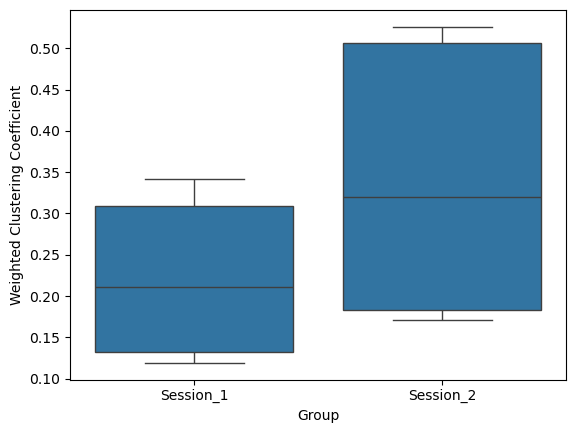

In [9]:
sns.boxplot(data=metrics.dropna(), x='Group', y='Weighted Clustering Coefficient')

In [14]:
metrics['Subject']

0     1
1     2
2     3
4     5
5     6
6     7
7     8
8     9
9     1
10    2
11    3
13    5
14    6
15    7
16    8
17    9
Name: Subject, dtype: int64

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ayahuasca, x='Subject', y='TEMP', palette=colors)


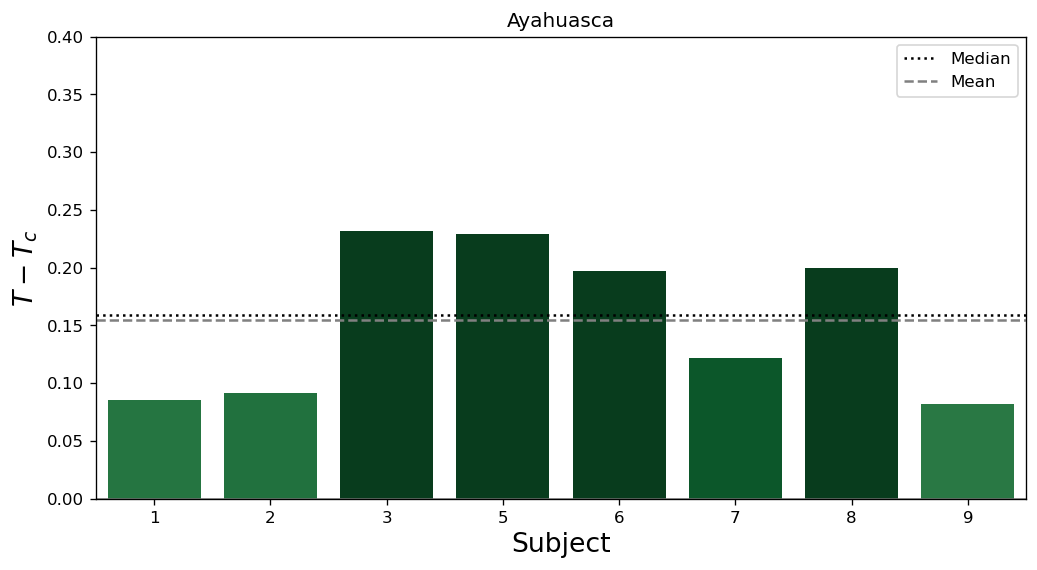

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.DataFrame(placebo).reset_index(), x='Subject', y='TEMP', palette=colors)


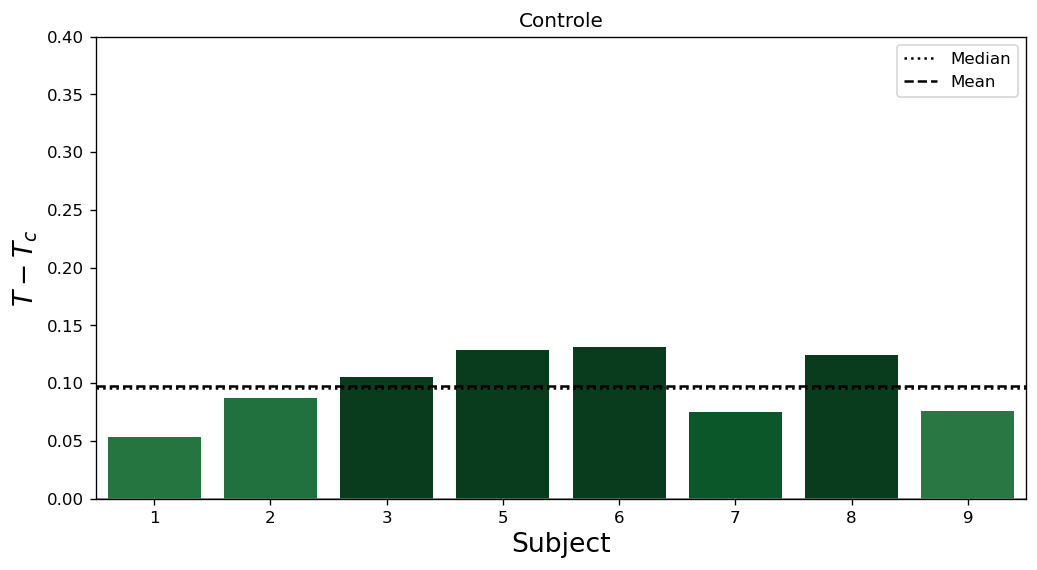

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.DataFrame(result).reset_index(), x='Subject', y='TEMP', palette=colors)


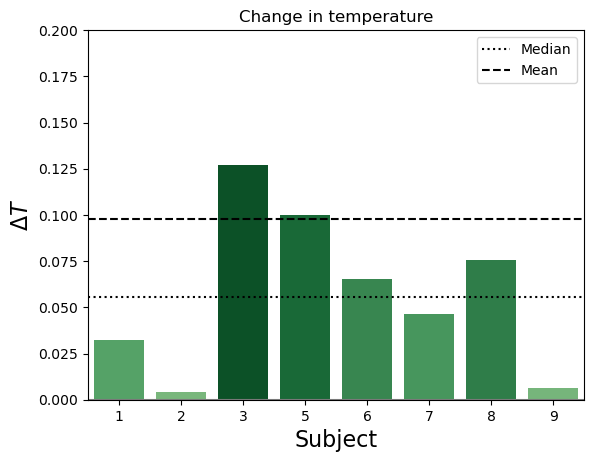

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(metrics, x='Group', y='TEMP',palette=colors)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Control', 'Ayahuasca'],  fontsize=16)


TEMP T-TEST TtestResult(statistic=2.2406514904449724, pvalue=0.041783596322208426, df=14.0)


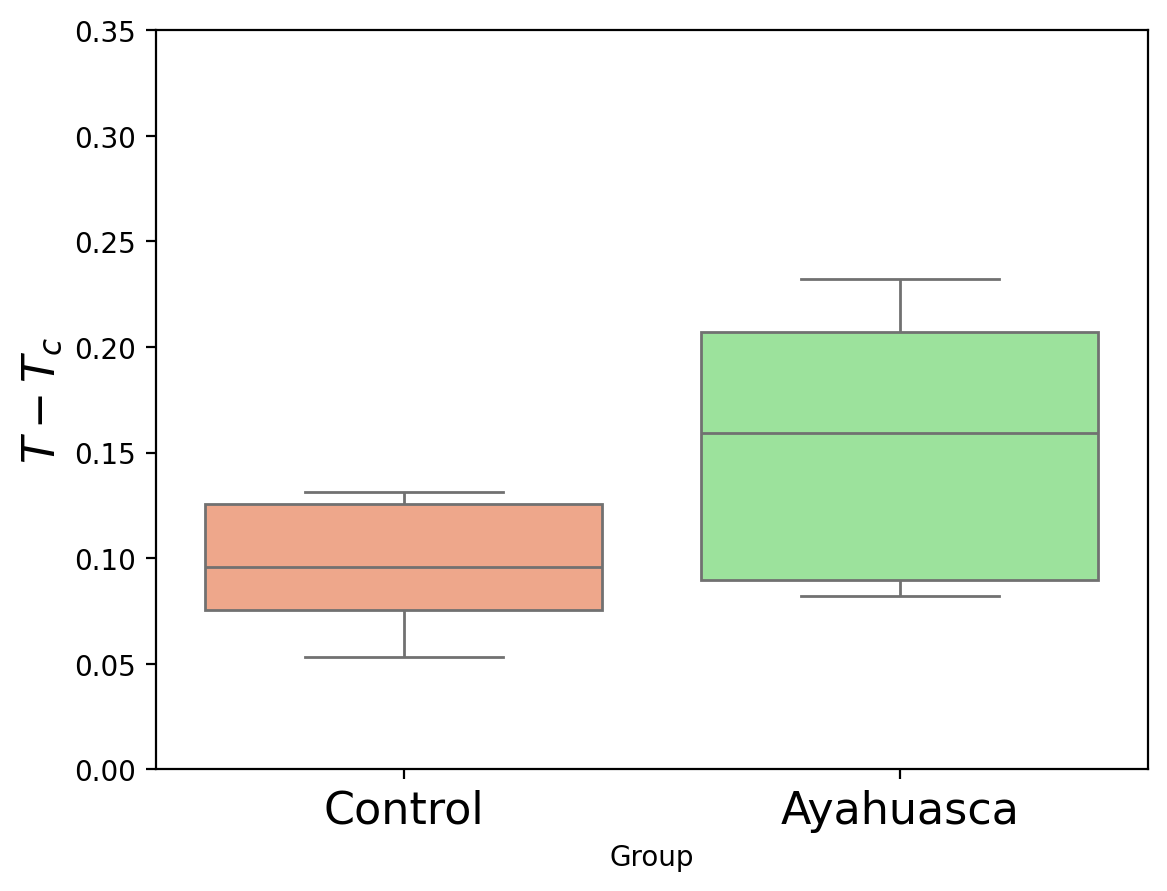

Delta T T-TEST TtestResult(statistic=3.7090757365530846, pvalue=0.007564021520023283, df=7)


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(result, y='TEMP',palette=colors)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_59371/510859895.py:90: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  g = sns.boxplot(result, y='TEMP',palette=colors)


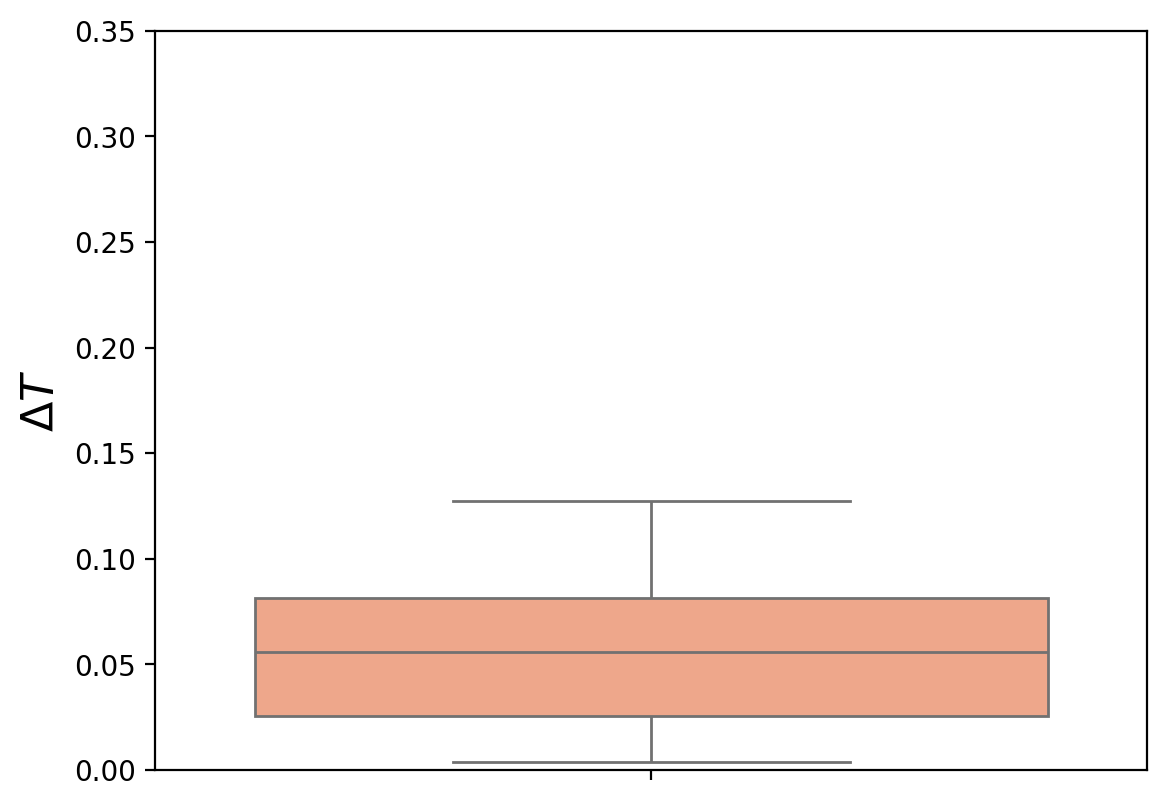

In [18]:
# Intra-subject
# Apply the function to each group using groupby
result = metrics[['Subject','MEAN','STD','TEMP']].groupby('Subject').diff().dropna()
result['Subject'] = [1,2,3,5,6,7,8,9]

group_o = metrics[metrics.Group == 'Session_1']
group_j = metrics[metrics.Group == 'Session_2']

from scipy import stats


ayahuasca = group_j[['Subject', 'TEMP']]
placebo = group_o[['Subject', 'TEMP']]

plt.figure(figsize=(10,5), dpi=120)
# Calculate the mean
mean_value = ayahuasca['TEMP'].mean()

# Normalize the values to create a gradient
#norm = plt.Normalize(ayahuasca['Change'].min(), ayahuasca['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
colors = [sm.to_rgba(val) for val in ayahuasca['TEMP']]

# Plotting
plt.title('Ayahuasca')
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=ayahuasca, x='Subject', y='TEMP', palette=colors)
plt.ylabel(r'$ T - T_c$',  fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=ayahuasca['TEMP'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='grey', linestyle='--', label='Mean')
plt.ylim(0,.4)
plt.legend()
plt.show()

plt.figure(figsize=(10,5), dpi=120)
plt.title('Controle')
# Calculate the mean
mean_value = placebo['TEMP'].mean()

# Normalize the values to create a gradient
#norm = plt.Normalize(placebo['Change'].min(), placebo['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
colors = [sm.to_rgba(val) for val in ayahuasca['TEMP']]
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=pd.DataFrame(placebo).reset_index(), x='Subject', y='TEMP', palette=colors)
plt.ylabel(r'$ T - T_c$',  fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=placebo['TEMP'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='black', linestyle='--', label='Mean')
plt.ylim(0,.4)
plt.legend()
plt.show()


plt.title('Change in temperature')
# Normalize the values to create a gradient
#norm = plt.Normalize(placebo['Change'].min(), placebo['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
colors = [sm.to_rgba(val) for val in result['TEMP']]
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=pd.DataFrame(result).reset_index(), x='Subject', y='TEMP', palette=colors)
plt.ylabel(r'$ \Delta T$',  fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=result['TEMP'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='black', linestyle='--', label='Mean')
plt.ylim(0,.2)
plt.legend()
plt.show()

colors = ['lightsalmon', 'lightgreen'] #['#808080', '#77dd77']

plt.figure(dpi=200)
# Display the resulting DataFrame
g = sns.boxplot(metrics, x='Group', y='TEMP',palette=colors)
#sns.swarmplot(result, x='Group', y='Change')
plt.ylabel(r'$ T - T_c$',  fontsize=16)
g.set_xticklabels(['Control', 'Ayahuasca'],  fontsize=16)
print('TEMP T-TEST', stats.ttest_ind(ayahuasca['TEMP'], placebo['TEMP']))
plt.ylim(0,.35)
plt.show()

colors = ['lightsalmon', 'lightgreen'] #['#808080', '#77dd77']

plt.figure(dpi=200)
# Display the resulting DataFrame
g = sns.boxplot(result, y='TEMP',palette=colors)
#sns.swarmplot(result, x='Group', y='Change')
plt.ylabel(r'$ \Delta T$',  fontsize=16)
#g.set_xticklabels(['Control', 'Ayahuasca'],  fontsize=16)
print('Delta T T-TEST', stats.ttest_1samp(result['TEMP'], 0))
plt.ylim(0,.35)


plt.show()


# plt.figure(dpi=200)

# ayahuasca = group_j[['Subject']]
# placebo = group_o[['Subject']]
# arr = [ayahuasca['TEMP'], placebo['TEMP']]
# # Perform t-test
# # Create a DataFrame for plotting
# data_to_plot = pd.DataFrame({'Placebo': placebo['TEMP'], 'Ayahuasca': ayahuasca['TEMP']})
# # Create the boxplot
# g = sns.boxplot(data=data_to_plot,palette=colors)
# # Set the x-tick labels
# g.set_xticks(range(len(arr)))
# g.set_xticklabels(['Placebo', 'Ayahuasca'],  fontsize=16)
# # Set y-label and y-limits
# plt.ylabel(r'$| T - T_c| $',  fontsize=16)
# #plt.ylim(2.20, 2.55)

# # Show the plot
# plt.show()
# print('After', stats.ttest_ind(ayahuasca['TEMP'], placebo['TEMP']))


(array([6.0000e+00, 4.4000e+01, 4.0200e+02, 1.9140e+03, 4.8080e+03,
        9.5430e+03, 1.4842e+04, 1.5200e+04, 7.6760e+03, 8.4300e+02]),
 array([-0.73707687, -0.56761787, -0.39815888, -0.22869988, -0.05924088,
         0.11021811,  0.27967711,  0.44913611,  0.6185951 ,  0.7880541 ,
         0.9575131 ]),
 <BarContainer object of 10 artists>)

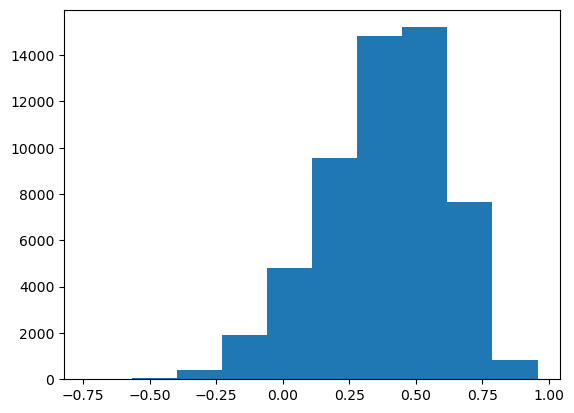

In [195]:
plt.hist(df[df.Subject == 5].iloc[0,:-8].values.ravel())

In [196]:
plt.imshow(ut.reconstruct_symmetric_matrix(333,df[df.Subject == 4].iloc[0,:-8],1),cmap='jet')
plt.colorbar()

IndexError: single positional indexer is out-of-bounds

In [197]:
df

,0,1,2,3,4,5,6,7,8,9,...,55276,55277,Group,Subject,Translation_X,Translation_Y,Translation_Z,Rotation_X,Rotation_Y,Rotation_Z
0,0.442759,0.002230,0.082323,-0.183352,0.523119,0.294239,0.199680,0.472208,0.463346,0.262173,...,0.333922,0.332701,Session_1,1,-0.674441,0.433430,0.213660,-0.001208,0.001425,-0.002440
1,0.268070,0.202346,0.737169,0.250835,0.828616,0.182173,0.226463,0.447637,0.438213,0.088292,...,0.249699,0.416163,Session_1,2,-0.037986,0.249407,-0.214045,0.000879,-0.000434,0.000140
2,0.058815,0.081820,0.506430,0.425055,0.620816,0.156665,0.607478,0.342432,0.500113,0.053986,...,0.598514,0.769916,Session_1,3,-0.067352,0.276022,-0.056782,0.000872,0.001325,-0.001008
4,0.561717,0.176743,0.410256,0.560069,0.953696,0.477427,0.506559,0.328224,0.646179,-0.084783,...,0.540748,0.509986,Session_1,5,0.485645,-0.145405,0.653654,-0.002815,0.000390,0.001951
5,0.200300,0.465535,0.737392,0.586687,0.748534,0.535838,0.556898,0.491310,0.441015,0.452477,...,0.255522,0.346758,Session_1,6,0.068819,0.379193,0.475124,0.000392,-0.001583,0.001308
6,0.323274,0.515932,0.678290,-0.023364,0.911146,-0.230344,0.029675,0.614827,0.423358,0.361695,...,0.360128,0.145809,Session_1,7,-0.021578,-0.037188,0.711768,-0.001981,-0.000031,0.000064
7,-0.260327,-0.094955,0.790844,0.185170,0.895895,0.731803,0.587385,0.404693,0.494128,0.195464,...,0.453876,0.634457,Session_1,8,-0.101443,0.056153,0.282582,-0.001701,-0.000283,-0.000273
8,-0.057734,0.191179,0.668905,0.304232,0.853607,0.342273,0.331226,0.318155,0.027459,0.275014,...,0.018869,0.232953,Session_1,9,-0.244065,0.139959,0.353782,-0.000845,0.000282,-0.001334
9,0.431036,0.072541,0.332817,0.020537,0.775505,-0.125466,-0.059329,0.313991,0.488120,0.583476,...,0.085509,0.690206,Session_2,1,-1.471678,-0.994598,-2.790767,0.013579,0.008334,-0.002331
10,0.588021,0.101644,0.532064,0.436818,0.596060,0.416312,0.217898,0.131102,0.166626,0.509543,...,0.588222,0.458563,Session_2,2,-0.385261,0.330963,-0.026466,0.000615,-0.000845,-0.001339


In [135]:
y = metrics['TEMP']
X = metrics[['Translation_X','Translation_Y', 'Translation_Z', 'Rotation_X', 'Rotation_Y', 'Rotation_Z']]

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()
pred = mod.predict(X)

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   TEMP   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.141
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.401
Time:                        12:22:45   Log-Likelihood:                 1.0365
No. Observations:                  18   AIC:                             11.93
Df Residuals:                      11   BIC:                             18.16
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1965      1.675      0.117

/Users/rodrigo/miniconda3/envs/ising_gnn/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)
